In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import keras

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.pkl.gz')
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
x_train = x_train[:10000]

In [6]:
#my tips:Gauss sampling,sample Z
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


#my tips:loss(restruct X)+KL
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [7]:
batch_size = 100
original_dim = 784   #28*28
latent_dim = 2
intermediate_dim = 200
nb_epoch = 300
epsilon_std = 1.0

In [8]:
#my tips:encoding
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

W0218 11:17:23.111638 14332 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0218 11:17:23.155611 14332 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0218 11:17:23.162608 14332 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [9]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# my tips:get sample z(encoded)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
 
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

W0218 11:17:23.979140 14332 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [10]:
#This model will include all layers required in the computation of x given x_decoded_mean.
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.99, beta_2=0.999, amsgrad=False)
vae = Model(x, x_decoded_mean)
vae.compile(optimizer=adam, loss=vae_loss)

W0218 11:17:25.029546 14332 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0218 11:17:25.054524 14332 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0218 11:17:25.072512 14332 deprecation.py:323] From C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# train the VAE on MNIST digits
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 10000 samples, validate on 10000 samples
Epoch 1/300
 - 5s - loss: 218.2556 - val_loss: 192.3892
Epoch 2/300
 - 3s - loss: 186.2349 - val_loss: 182.5313
Epoch 3/300
 - 3s - loss: 178.1776 - val_loss: 175.9132
Epoch 4/300
 - 3s - loss: 173.4833 - val_loss: 172.7680
Epoch 5/300
 - 3s - loss: 170.2120 - val_loss: 170.2726
Epoch 6/300
 - 3s - loss: 167.9184 - val_loss: 168.7444
Epoch 7/300
 - 3s - loss: 166.5284 - val_loss: 167.7728
Epoch 8/300
 - 3s - loss: 165.1503 - val_loss: 166.0968
Epoch 9/300
 - 4s - loss: 163.7915 - val_loss: 165.4296
Epoch 10/300
 - 5s - loss: 162.4751 - val_loss: 164.0310
Epoch 11/300
 - 6s - loss: 161.5355 - val_loss: 163.4941
Epoch 12/300
 - 5s - loss: 160.8709 - val_loss: 162.2379
Epoch 13/300
 - 5s - loss: 159.9910 - val_loss: 162.0420
Epoch 14/300
 - 6s - loss: 159.4510 - val_loss: 162.0131
Epoch 15/300
 - 5s - loss: 158.8549 - val_loss: 161.4346
Epoch 16/300
 - 5s - loss: 158.3181 - val_loss: 160.9402
Epoch 17/300
 - 5s - loss: 157.8538 - val_loss:

Epoch 144/300
 - 3s - loss: 146.4581 - val_loss: 158.9407
Epoch 145/300
 - 4s - loss: 147.0668 - val_loss: 159.2143
Epoch 146/300
 - 3s - loss: 147.0800 - val_loss: 158.3109
Epoch 147/300
 - 4s - loss: 146.6456 - val_loss: 158.5817
Epoch 148/300
 - 6s - loss: 146.6519 - val_loss: 158.7777
Epoch 149/300
 - 4s - loss: 146.8821 - val_loss: 158.5304
Epoch 150/300
 - 5s - loss: 146.7932 - val_loss: 158.9118
Epoch 151/300
 - 5s - loss: 146.8082 - val_loss: 158.4150
Epoch 152/300
 - 5s - loss: 146.4993 - val_loss: 158.6140
Epoch 153/300
 - 5s - loss: 146.3595 - val_loss: 158.5954
Epoch 154/300
 - 5s - loss: 146.4114 - val_loss: 158.8661
Epoch 155/300
 - 4s - loss: 146.5395 - val_loss: 158.9231
Epoch 156/300
 - 4s - loss: 146.6332 - val_loss: 159.0436
Epoch 157/300
 - 4s - loss: 147.1340 - val_loss: 158.4999
Epoch 158/300
 - 4s - loss: 146.8587 - val_loss: 159.6448
Epoch 159/300
 - 3s - loss: 147.0128 - val_loss: 158.7108
Epoch 160/300
 - 5s - loss: 146.3778 - val_loss: 158.5556
Epoch 161/300


Epoch 286/300
 - 3s - loss: 146.1806 - val_loss: 160.6731
Epoch 287/300
 - 3s - loss: 146.3191 - val_loss: 159.8526
Epoch 288/300
 - 3s - loss: 145.6906 - val_loss: 159.4696
Epoch 289/300
 - 2s - loss: 145.1933 - val_loss: 160.1559
Epoch 290/300
 - 3s - loss: 145.1710 - val_loss: 160.1868
Epoch 291/300
 - 3s - loss: 145.0466 - val_loss: 159.3942
Epoch 292/300
 - 3s - loss: 144.8625 - val_loss: 160.1693
Epoch 293/300
 - 3s - loss: 144.5871 - val_loss: 159.1865
Epoch 294/300
 - 3s - loss: 144.6524 - val_loss: 159.5911
Epoch 295/300
 - 2s - loss: 144.9374 - val_loss: 159.9667
Epoch 296/300
 - 3s - loss: 145.0964 - val_loss: 160.1589
Epoch 297/300
 - 3s - loss: 145.7910 - val_loss: 160.1559
Epoch 298/300
 - 3s - loss: 145.8659 - val_loss: 160.7811
Epoch 299/300
 - 3s - loss: 146.0283 - val_loss: 160.5194
Epoch 300/300
 - 3s - loss: 145.4603 - val_loss: 160.9789


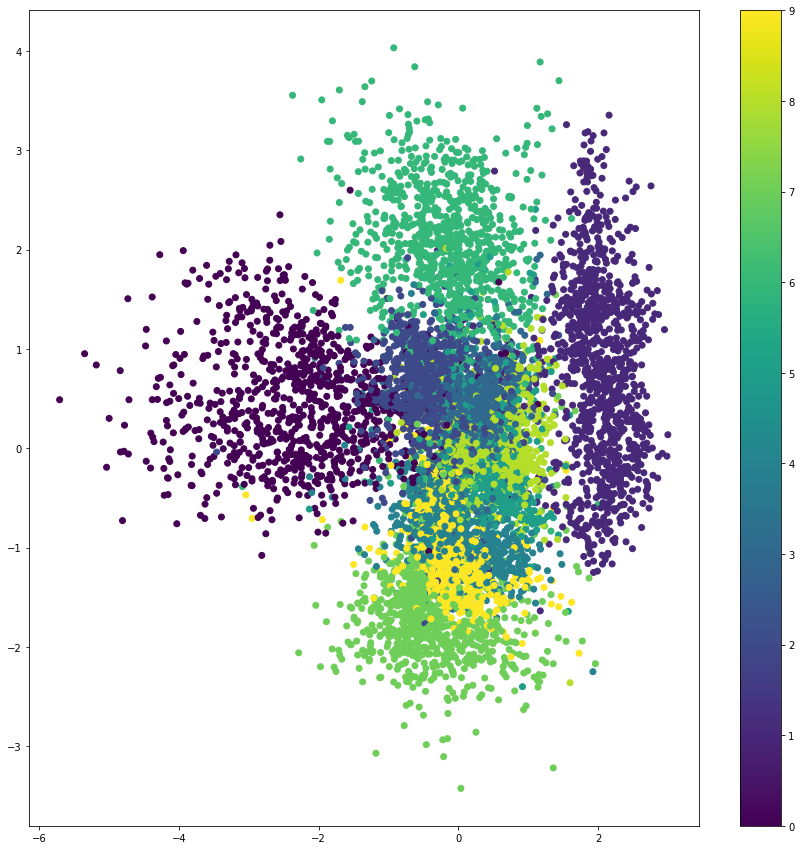

In [12]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
 
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(15,15))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
 
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        
 
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        print(yi)